# Discover data on EODC catalog and read it - Sentinel 1

Earth Observation (EO) data is wide term for data coming from satellite observations of our planet, including satellite imagery (visible and the rest of the electromagnetic spectrum), thermal data, sea level measurements, atmospheric observations and so on. This data can range from "raw" observations from satellite sensors to human-interpretable imagery. Therefore data providers can range from space agencies owning satellites, to companies or research groups which publish processed measurements. Either way, those institutions often give access to picobytes of datasets that are available with different levels of processing and can be accessed with different paradigm. Sometimes it is web interface, sometimes data can be downloaded with Application Programming Interface (API). API is bridge between user, application submitting request, and server, that operates database.

This choice of data providers leads to inconvenience of the user not being aware of what is available, for what region of the world and in which timeframe. Morevoer, usually separate accounts have to be made even for freely available data. For that reasons, community has established SpatioTemporal Asset Catalog (STAC), standard that uses common structure to describe data. In other words, metadata can be accessed with STAC which simplifies data discovery. This metadata can be: provider of satellite imagery, platform (satellite), time moment at which imagery was taken, spatial position and coordinate reference system, acquisition methods and so on. 

Discovering Earth Observation (EO) data can be done with SpatioTemporal Asset Catalog (STAC), a community standard that uses common structure to describe data. Earth Observation (EO) data can be published by several providers and accessing it can usually be done with Application Programming Interface (API). API is bridge between user, application submitting request, and server, that operates database. Different EO data providers have different APIs and new code has to be written from scratch for each. Therefore, STAC makes this data access easier by cataloging data in common way.

It is important to note that with STAC, one can search for data and check what is available, however STAC is not tool developed for downloading datasets. It stores geospatial metadata, which for satellite imagery could be: provider of imagery, description of dataset and acquisition methods, time moment at which imagery was taken, spatial position and coordinate reference system, and so on.

The STAC Specification has four specifications: STAC Item, STAC Catalog, STAC Collection and STAC API. STAC Item is spatiotemporal unit, for instance a SAR image at moment of acquisition. Each must have type (of GeoJSON object), id, STAC version, geometry, bounding box, links (to description, license, quicklook, collection folder, ...), assets (bands of data, ...), and properties (coordinate reference system, ...). Those field names are required, but their structure and what metadata is stored in them is determined by data provider. STAC Catalog links items together, while STAC Collection extends Catalog with information such as links, temporal extent, license and so on.

This notebook shows example of how to access EODC Catalogue with STAC in python, using pystac. EODC is EO data and High Peformance Computing service provider. Firstly, STAC client has to be loaded in python and with it EODC catalogue.

In [6]:
import pystac_client
import folium

eodc_catalog = pystac_client.Client.open(
    "https://stac.eodc.eu/api/v1"
)

eodc_catalog

<Client id=stac-fastapi>

The URL [https://stac.eodc.eu/api/v1](https://stac.eodc.eu/api/v1), served over Hypertext Transfer Protocol (HTTP), is STAC-compliant API endpoint (specific URL address where API service is available) that leads to EODC Catalogue. Besides EODC, others can be found on [STAC Index](https://stacindex.org/catalogs), such as United States Geological Survey (USGS) Landsat imagery, Sentinel Hub, Copernicus Data Space Ecosystem and so on. Briefly - STAC can be used to search, discover and access metadata of these datasets with same code. [EODC Catalogue](https://services.eodc.eu/browser/#/?.language=en) can be accessed on the web as well.

Each catalog, composed by different providers, has many collections. To get all collections of a catalog, one could print all of them and their ids, which are used to fetch them from the catalog. 

In [7]:
collections = eodc_catalog.get_collections()

max_length = max(len(collection.id) for collection in collections) #length of string of collection.id, for pretty print

for collection in eodc_catalog.get_collections():
    print(f"{collection.id.ljust(max_length)} : {collection.title}")

SENTINEL2_L2A                     : Sentinel-2 MSI Products: Level-2A data
SENTINEL2_GRI_L1C                 : Multi-Layer Copernicus Sentinel-2 GRI in L1C
SENTINEL1_HPAR                    : SENTINEL1 Harmonic Parameters
DOP_AUT_K_KLAGENFURT              : Digital Orthophotos (DOP) Austria - Land Kärnten: Orthofotos Flugblock Klagenfurt
DOP_AUT_K_OSTTIROL                : Digital Orthophotos (DOP) Austria - Land Kärnten: Orthofotos Flugblock Osttirol
DOP_AUT_K_TAMSWEG                 : Digital Orthophotos (DOP) Austria - Land Kärnten: Orthofotos Flugblock Tamsweg
DOP_AUT_K_VILLACH                 : Digital Orthophotos (DOP) Austria - Land Kärnten: Orthofotos Flugblock Villach
DOP_AUT_K_WOLFSBERG               : Digital Orthophotos (DOP) Austria - Land Kärnten: Orthofotos Flugblock Wolfsberg
DOP_AUT_K_ZELL_AM_SEE             : Digital Orthophotos (DOP) Austria - Land Kärnten: Orthofotos Flugblock Zell am See
DOP_AUT_K_ZELTWEG                 : Digital Orthophotos (DOP) Austria - Land K

To get a specific collection from the above list, we should put id into `client.get_collection()` method. It can be displayed with its description, id, temporal and spatial extend, licence, etc. This depends on a provider.

In [8]:
colllection_id = 'SENTINEL1_SIG0_20M'

collection = eodc_catalog.get_collection(colllection_id)
collection

<CollectionClient id=SENTINEL1_SIG0_20M>

Each collection has items, which is one spatio-temporal instance of EO imagery. If items are needed for specific timeframe and for specific region of interest, those could be defined as query in the following way.

In [9]:
from rich.console import Console
console = Console()

#time_range = "2022-01-01/.." # up to current date, an open range
time_range = "2022-08-01/2022-08-15" # closed range

# GEOJSON can be created on geojson.io
# This specific area of interest is a rectangle, but since it is closed polygon it seems like it has five nodes
area_of_interest = {
  "coordinates": [
          [
            [
              53.44795646225646,
              -11.443518251360018
            ],
            [
              41.96628106391725,
              -11.443518251360018
            ],
            [
              41.96628106391725,
              -26.238295466626667
            ],
            [
              53.44795646225646,
              -26.238295466626667
            ],
            [
              53.44795646225646,
              -11.443518251360018
            ]
          ]
        ],
        "type": "Polygon"
}

From previously loaded catalog with STAC client, a search can be done. Search can have several input parameters, for example if area of interest is specified in geojson format - one should use `interescts`, like below. Another way would be the bounding box, that could be a list, a tuple or iterator, but generally the list should have the following format:

In [10]:
latmin, latmax = -26.238295466626667, -11.443518251360018 # watch out for the sign, it determines W-E direction!
lonmin, lonmax = 41.96628106391725, 53.44795646225646
bounding_box = [lonmin, latmin, lonmax, latmax]

search = eodc_catalog.search(
    collections=colllection_id, # can also be a list of several collections
    intersects=area_of_interest, # search by geojson
    #bbox=bounding_box, # search by bounding box
    datetime=time_range,
    #max_items = 100 # number of max items to load, if commented it will load all of them
)

items_eodc = search.item_collection()
console.print(f"On EODC we found {len(items_eodc)} items for the given search query")

On EODC we found 105 items for the given search query

Here is a way to quickly check how the data looks on a map.

In [11]:
map = folium.Map(location=[-26, 30], zoom_start=5)

folium.GeoJson(area_of_interest, name="Area of Interest").add_to(map)

for item in items_eodc:
    image_url = item.assets['thumbnail'].href # url leading to display of an item, can also be used as hyperlink
    bounds = item.bbox
    folium.raster_layers.ImageOverlay(
        image=image_url,
        bounds=[[bounds[1], bounds[0]], [bounds[3], bounds[2]]], # bounds of item
        ).add_to(map)

folium.LayerControl().add_to(map)

map

EODC items could be displayed, without downloading data, by accessing asset "thumbnail" and hyperlink reference (href) to it, which is still part of metadata. Good practice is to check out what structure is of each catalogue per item. For example, for EODC, an item has following assets:

In [12]:
item

<Item id=SIG0_20220802T021012_D020_E087N033T3_AF020M_V1M1R1_S1AIWGRDH>

Example thumbnail of last item from the loop:

In [13]:
item.assets['thumbnail'].href

'https://data.eodc.eu/collections/SENTINEL1_SIG0_20M/V1M1R1/EQUI7_AF020M/E087N033T3/SIG0_20220802T021012__VV_D020_E087N033T3_AF020M_V1M1R1_S1AIWGRDH_TUWIEN.tif/thumbnail'

To see how metadata structure (in item assets, properties and links) can differ from catalog to catalog, let's check out [Copernicus Data Space Ecosystem](https://dataspace.copernicus.eu/) (CDSE) STAC API, found on [STAC Index](https://stacindex.org/catalogs).

In [14]:
copernicus_catalog = pystac_client.Client.open(
    "https://catalogue.dataspace.copernicus.eu/stac"
)

collections = copernicus_catalog.get_collections()

max_length = max(len(collection.id) for collection in collections) #length of string of collection.id, for pretty print

for collection in copernicus_catalog.get_collections():
    print(f"{collection.id.ljust(max_length)} : {collection.title}")

copernicus_catalog

COP-DEM        : COP-DEM
S2GLC          : S2GLC
TERRAAQUA      : TERRAAQUA
SENTINEL-3     : SENTINEL-3
SENTINEL-5P    : SENTINEL-5P
SENTINEL-1-RTC : SENTINEL-1-RTC
SENTINEL-1     : SENTINEL-1
SMOS           : SMOS
LANDSAT-7      : LANDSAT-7
CCM            : CCM
LANDSAT-5      : LANDSAT-5
LANDSAT-8      : LANDSAT-8
ENVISAT        : ENVISAT
SENTINEL-6     : SENTINEL-6
GLOBAL-MOSAICS : GLOBAL-MOSAICS
SENTINEL-2     : SENTINEL-2


<Client id=Catalogue>

Lets load Sentinel-1 metadata as well.

In [15]:
colllection_id = "SENTINEL-1"

search = copernicus_catalog.search(
    collections=colllection_id,
    bbox=bounding_box, # search by predefined bounding box
    datetime=time_range,
)

items_copernicus = search.item_collection()
console.print(f"On Copernicus we found {len(items_copernicus)} items for the given search query")

On Copernicus we found 280 items for the given search query

Lets check the structure of a CDSE item.

In [16]:
items_copernicus[0]

<Item id=S1A_IW_SLC__1SDV_20220811T153357_20220811T153427_044506_054FAB_66B6.SAFE>

In [17]:
items_copernicus[0].assets['QUICKLOOK'].href # URL below wil ldownload .png file!

'https://catalogue.dataspace.copernicus.eu/odata/v1/Assets(f74b1f16-8441-433b-81df-7216cd19eb3e)/$value'

In [18]:
from IPython.core.display import HTML

# Example URL from your Copernicus dataset
image_url = 'https://catalogue.dataspace.copernicus.eu/path_to_your_image.png'

# Embed the image using HTML
HTML(f'<img src="{image_url}" width="600"/>')  # You can adjust the width as needed


One can notice that this time thumbnail is designated as quicklook and it is in .png format, that is downloadable.

In [19]:
# map = folium.Map(location=[-26, 30], zoom_start=5)

# folium.GeoJson(area_of_interest, name="Area of Interest").add_to(map)

# for item in items_eodc:
#     image_url = item.assets['QUICKLOOK'].href
#     bounds = item.bbox
#     folium.raster_layers.ImageOverlay(
#         image=image_url,
#         bounds=[[bounds[1], bounds[0]], [bounds[3], bounds[2]]], # bounds of item
#         ).add_to(map)

# folium.LayerControl().add_to(map)

# map

In [20]:
# copernicus_catalog = pystac_client.Client.open(
#     "https://esa-earthcode.github.io/open-science-catalog-metadata/catalog.json"
# )

# collections = copernicus_catalog.get_collections()

# max_length = max(len(collection.id) for collection in collections) #length of string of collection.id, for pretty print

# for collection in copernicus_catalog.get_collections():
#     print(f"{collection.id.ljust(max_length)} : {collection.title}")

# copernicus_catalog

In [21]:
# colllection_id = "5c476560-e0a3-554a-9187-187a90da1309"

# search = copernicus_catalog.search(
#     collections=colllection_id,
#     bbox=bounding_box, # search by predefined bounding box
#     datetime=time_range,
# )

# items_copernicus = search.item_collection()
# console.print(f"On Copernicus we found {len(items_copernicus)} items for the given search query")

In [22]:
# copernicus_catalog = pystac_client.Client.open(
#     "https://esa-earthcode.github.io/open-science-catalog-metadata/catalog.json"
# )

# collections = copernicus_catalog.get_collections()

# copernicus_catalog

In [23]:
esa_catalog = pystac_client.Client.open(
    "https://esa-earthcode.github.io/open-science-catalog-metadata/catalog.json"
)

collections = esa_catalog.get_collections()


/home/ljovic/miniconda3/envs/eodc2/lib/python3.11/site-packages/pystac_client/client.py:190: NoConformsTo: Server does not advertise any conformance classes.
  warnings.warn(NoConformsTo())


In [24]:
collections = list(esa_catalog.get_collections())

/home/ljovic/miniconda3/envs/eodc2/lib/python3.11/site-packages/pystac_client/client.py:440: FallbackToPystac: Falling back to pystac. This might be slow.
  self._warn_about_fallback("COLLECTIONS", "FEATURES")


In [25]:
for collection in collections:
    print(f"ID: {collection.id}")
    print(f"Title: {collection.title}")
    print(f"Description: {collection.description}")
    print("-" * 40)


In [26]:
for link in esa_catalog.get_links():
    print(f"Rel: {link.rel}, Href: {link.href}")



Rel: self, Href: https://esa-earthcode.github.io/open-science-catalog-metadata/catalog.json
Rel: root, Href: ./catalog.json
Rel: child, Href: ./projects/catalog.json
Rel: child, Href: ./themes/catalog.json
Rel: child, Href: ./variables/catalog.json
Rel: child, Href: ./processes/catalog.json
Rel: child, Href: ./eo-missions/catalog.json
Rel: child, Href: ./products/catalog.json


In [27]:
from pystac_client import Client

# Base URL for the catalog
base_url = "https://esa-earthcode.github.io/open-science-catalog-metadata/"

# Relative paths to sub-catalogs
sub_catalogs = [
    "projects/catalog.json",
    "themes/catalog.json",
    "variables/catalog.json",
    "processes/catalog.json",
    "eo-missions/catalog.json",
    "products/catalog.json"
]

# List to hold all collections from all sub-catalogs
all_collections = []

# Iterate through each sub-catalog
for sub_catalog in sub_catalogs:
    sub_catalog_url = base_url + sub_catalog
    print(f"Opening sub-catalog: {sub_catalog_url}")
    
    # Open the sub-catalog
    sub_catalog_obj = Client.open(sub_catalog_url)
    
    # Retrieve collections from the sub-catalog
    collections = list(sub_catalog_obj.get_collections())
    
    max_length = max(len(collection.id) for collection in collections)

    for collection in collections:
        print(f"{collection.id.ljust(max_length)} : {collection.title}")
        all_collections.append({
            "ID": collection.id,
            "Title": collection.title,
            "Description": collection.description
            })

print(f"\nTotal collections found: {len(all_collections)}")


Opening sub-catalog: https://esa-earthcode.github.io/open-science-catalog-metadata/projects/catalog.json
3d-earth                                                                                                                                                                                             : 3D-EARTH
4d-antarctica                                                                                                                                                                                        : 4D-ANTARCTICA
4datlantic-ebus-primus                                                                                                                                                                               : 4DATLANTIC EBUS PRIMUS
4d-greenland                                                                                                                                                                                         : 4D-Greenland
4dionosphere-swarm-vip                  

ValueError: max() arg is an empty sequence

In [ ]:
for collection in collections:
    print(f"{collection.id.ljust(max_length)} : {collection.title}")

In [ ]:
for collection in eodc_catalog.get_collections():
    print(colllection_id)

In [ ]:
collections = eodc_catalog.get_collections()

max_length = max(len(collection.id) for collection in collections) #length of string of collection.id, for pretty print

for collection in eodc_catalog.get_collections():
    print(f"{collection.id.ljust(max_length)} : {collection.title}")

metadata (find) + load

## Data Reading

STAC can be useful tool for discovery of data, however it only loads metadata. This saves memory, but if one would like to do further analysis the data has to be loaded into memory or downloaded on disk.

Library used for loading data is odc-stac.


In [28]:
from odc import stac as odc_stac

In [29]:
collection_id="SENTINEL1_SIG0_20M"

start_date = "2023-01-01"
end_date = "2023-10-31"

query = eodc_catalog.search(bbox=bounding_box,
                        collections=[collection_id],
                        datetime=f"{start_date}/{end_date}",
                        )

q_items = sorted(query.items(), key=lambda x: x.id)

In [30]:
collection_id="SENTINEL1_SIG0_20M"

bbox = [15.6, 47.7, 16.6, 48.7]  # [lon_min, lat_min, lon_max, lat_max]
start_date = "2022-03-01"
end_date = "2022-04-01"

query = eodc_catalog.search(bbox=bounding_box,
                        collections=collection_id,
                        datetime=f"{start_date}/{end_date}",
                        )

q_items = sorted(query.items(), key=lambda x: x.id) #sorting items by id, as in EODC catalog they can be sorted by dates this way

To check again structure of an item and what bands it poses.

In [32]:
q_items[0]

<Item id=SIG0_20220301T154123_A057_E078N021T3_AF020M_V1M1R1_S1AIWGRDH>

In [6]:
from pystac_client import Client
stac_api = "https://stac.eodc.eu/api/v1"
client = Client.open(stac_api)

collection_id="AI4SAR_SIG0"

bbox = [15.6, 47.7, 16.6, 48.7]  # [lon_min, lat_min, lon_max, lat_max]
start_date = "2023-01-01"
end_date = "2023-12-31"

query_prop = {
    "sat:relative_orbit": {"eq": 146,}
        }

query = client.search(bbox=bbox,
                        collections=[collection_id],
                        datetime=f"{start_date}/{end_date}",
                        query = query_prop,
                        )
#q_items = list(query.get_items())
q_items = sorted(query.items(), key=lambda x: x.id)

In [16]:
collection_id="SENTINEL1_SIG0_20M"

bbox = [15.6, 47.7, 16.6, 48.7]  # [lon_min, lat_min, lon_max, lat_max]
start_date = "2022-01-01"
end_date = "2022-02-20"

query = client.search(bbox=bbox,
                        collections=[collection_id],
                        datetime=f"{start_date}/{end_date}",
                        )
q_items = sorted(query.items(), key=lambda x: x.id)

In [17]:
q_items

[<Item id=SIG0_20220101T164242_A073_E051N015T3_EU020M_V0M2R4_S1AIWGRDH>,
 <Item id=SIG0_20220101T164307_A073_E051N015T3_EU020M_V0M2R4_S1AIWGRDH>,
 <Item id=SIG0_20220101T164332_A073_E051N015T3_EU020M_V0M2R4_S1AIWGRDH>,
 <Item id=SIG0_20220103T051759_D095_E051N015T3_EU020M_V0M2R4_S1AIWGRDH>,
 <Item id=SIG0_20220103T051824_D095_E051N015T3_EU020M_V0M2R4_S1AIWGRDH>,
 <Item id=SIG0_20220103T051849_D095_E051N015T3_EU020M_V0M2R4_S1AIWGRDH>,
 <Item id=SIG0_20220106T165045_A146_E051N015T3_EU020M_V0M2R4_S1AIWGRDH>,
 <Item id=SIG0_20220106T165110_A146_E051N015T3_EU020M_V0M2R4_S1AIWGRDH>,
 <Item id=SIG0_20220106T165135_A146_E051N015T3_EU020M_V0M2R4_S1AIWGRDH>,
 <Item id=SIG0_20220108T163440_A175_E051N015T3_EU020M_V1M1R1_S1AIWGRDH>,
 <Item id=SIG0_20220108T163505_A175_E051N015T3_EU020M_V1M1R1_S1AIWGRDH>,
 <Item id=SIG0_20220108T163530_A175_E051N015T3_EU020M_V1M1R1_S1AIWGRDH>,
 <Item id=SIG0_20220110T050947_D022_E051N015T3_EU020M_V0M2R4_S1AIWGRDH>,
 <Item id=SIG0_20220110T051012_D022_E051N015T3_EU02

In [21]:
q_items[0]

<Item id=SIG0_20220101T164242_A073_E051N015T3_EU020M_V0M2R4_S1AIWGRDH>

In [22]:
from odc import stac as odc_stac


# As we are working with Synthetic-aperture radar data, we have polarisation bands, Vecrtical-Vertical and Vertical-Horizontal
bands = ("VV", "VH")
crs = "EPSG:4326"
bbox = [15.6, 47.7, 16.6, 48.7]
res = 0.00018 # 20 meter in degree


sig0_ds = odc_stac.stac_load(q_items,
                        bands=bands,
                        crs=crs,
                        resolution=res,
                        bbox=bbox,
                        use_overviews=False,
                        )

In [23]:
def scale_image(arr, nodata, vmin=None, vmax=None):
    
    v_idx = arr!=nodata
    
    v = arr[v_idx]

    if vmin is None:
        
        vmin = np.min(v)
    if vmax is None:
        vmax = np.max(v)
    
    out = np.copy(arr)
    # scale between 1 and 255 and leave 0 for nodata
    out = (out-vmin) * (254/(vmax-vmin)) + 1
    out[~v_idx] = 0

    return out.astype(np.uint8)

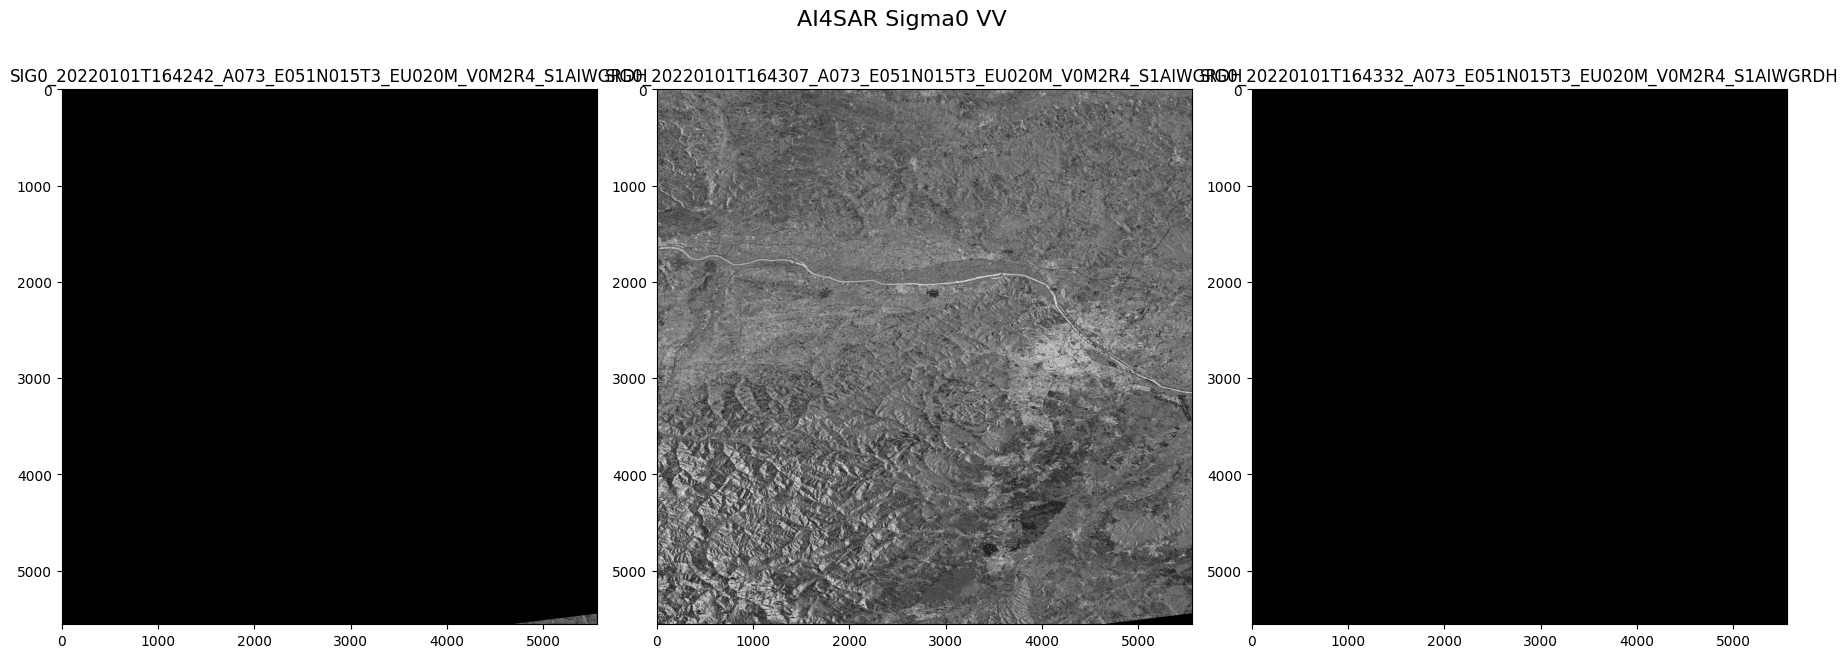

In [27]:
import matplotlib.pyplot as plt
import numpy as np

fig1 = plt.figure(figsize=(18, 6))
fig1.suptitle('AI4SAR Sigma0 VV', fontsize=16, y=1.05)
nodata = -9999

for i in range(3):
    
    img = sig0_ds.VV[i,:,:].to_numpy()
    name = q_items[i].id

    gray_img = scale_image(img, nodata, vmin=-170, vmax=20)

    ax = fig1.add_subplot(1, 3, i+1)
    ax.set_title(name)
    ax.imshow(gray_img, cmap='gray')


plt.tight_layout()

In [26]:
for idx, i in enumerate(range(5, 7)):  # Corrected range syntax

    img = sig0_ds.VV[i,:,:].to_numpy()
    name = q_items[i].id

    gray_img = scale_image(img, nodata, vmin=-170, vmax=20)

    ax = fig1.add_subplot(1, 3, idx + 1)  # Using 'idx + 1' for subplot index
    ax.set_title(name)
    ax.imshow(gray_img, cmap='gray')

plt.tight_layout()
plt.show()

<Figure size 640x480 with 0 Axes>

In [52]:
# As we are working with Synthetic-aperture radar data, we have polarisation bands, Vecrtical-Vertical and Vertical-Horizontal
bands = ("VV", "VH")
crs = "EPSG:4326"
bbox = [15.6, 47.7, 16.6, 48.7]
res = 0.00018 # 20 meter in degree


sig0_ds = odc_stac.stac_load(q_items,
                        bands=bands,
                        crs=crs,
                        resolution=res,
                        bbox=bbox,
                        use_overviews=False,
                        )

: 

In [ ]:
sig0_ds

<xarray.Dataset>
Dimensions:      (latitude: 5556, longitude: 5557, time: 136)
Coordinates:
  * latitude     (latitude) float64 48.7 48.7 48.7 48.7 ... 47.7 47.7 47.7 47.7
  * longitude    (longitude) float64 15.6 15.6 15.6 15.6 ... 16.6 16.6 16.6 16.6
    spatial_ref  int32 4326
  * time         (time) datetime64[ns] 2022-03-01T15:41:23 ... 2022-04-01T15:...
Data variables:
    VV           (time, latitude, longitude) int16 -9999 -9999 ... -9999 -9999
    VH           (time, latitude, longitude) int16 -9999 -9999 ... -9999 -9999

In [46]:
import numpy as np

def scale_image(arr, nodata, vmin=None, vmax=None):
    
    v_idx = arr!=nodata
    
    v = arr[v_idx]

    if vmin is None:
        
        vmin = np.min(v)
    if vmax is None:
        vmax = np.max(v)
    
    out = np.copy(arr)
    # scale between 1 and 255 and leave 0 for nodata
    out = (out-vmin) * (254/(vmax-vmin)) + 1
    out[~v_idx] = 0

    return out.astype(np.uint8)

In [35]:
img = sig0_ds.VV[0,:,:].to_numpy()

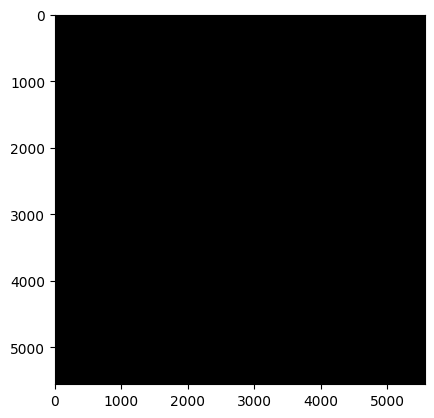

In [47]:
import matplotlib.pyplot as plt
nodata = -9999
gray_img = scale_image(img, nodata, vmin=-170, vmax=20)


plt.imshow(gray_img, cmap='gray')